In [6]:
# Ref: https://www.youtube.com/watch?v=Mlay1B7_9Ug

### Initializing the keys

In [7]:
import os
from dotenv import load_dotenv

load_dotenv()

from langchain_openai import ChatOpenAI

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.environ.get("TAVILY_API_KEY")


llm = ChatOpenAI(model="gpt-4-1106-preview")

### Create Agent function

In [8]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor



### Creation of Tools 

- Tavily Search tool
- PythonREPLTool

In [9]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

python_repl_tool = PythonREPLTool()

### RAG Setup with vector DB

In [10]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

### Reading the txt files from source directory

loader = DirectoryLoader('./perfume_recommendation_example/source', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

###  BGE Embddings

from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

### Creating Retriever using Vector DB

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

C:\Users\201\AppData\Local\Temp\ipykernel_13572\1953947142.py:27: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(
c:\Users\201\miniforge3\envs\multiagent_test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

### RAG Tool : Python function -> tool

In [12]:
@tool
def RAG(state):

    """Use this to execute RAG. If the question is related to Japan or Sports, using this tool retrieve the results."""

    print('-> Calling RAG ->')
    question = state
    print('Question:',question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

### Agent node 
 - takes state , agent and name as input 
 - return mesage as HumanMessage with name

In [13]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Supervisor Chain creation 

Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed

- Has access and information about it's memebers. 
- members = ["RAG" , "Researcher", "Coder"]
- options = ["FINISH"] + members
- "Given the conversation above, who should act next?"
   " Or should we FINISH? Select one of: {options}"

- Router -> function_def

In [14]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["RAG" , "Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Use RAG tool when questions "
     "are related to Japan or of Sports category. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

C:\Users\201\AppData\Local\Temp\ipykernel_13572\4014504238.py:47: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


### Creation of workflow with below nodes 

Agent ->> Node (functools.partial)

 - Research Node
 - Code Node
 - RAG Node

In [15]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")


RAG_agent = create_agent(
    llm,
    [RAG],
    "Use this tools when questions are related to Japan or of Sports category.",
)
rag_node = functools.partial(agent_node, agent=RAG_agent, name="RAG")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("RAG", rag_node)
workflow.add_node("supervisor", supervisor_chain)

In [16]:
members

['RAG', 'Researcher', 'Coder']

### Creation of edges

In [17]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

In [18]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='The code `print(\'Hello World\')` has been executed and "Hello World" has been printed to the terminal.', additional_kwargs={}, response_metadata={}, name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [19]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="What James McIlroy is aiming in sports?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'RAG'}}
----
-> Calling RAG ->
Question: James McIlroy
{'RAG': {'messages': [HumanMessage(content='James McIlroy, the professional runner from Northern Ireland, is aiming to win his first major title at an upcoming event in Madrid. At 28 years old, it appears that he is looking to achieve a significant milestone in his career as an 800 metres competitor.', additional_kwargs={}, response_metadata={}, name='RAG')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="We have now obtained the following nominal GDP values for India in recent years:\n\n- In the fiscal year 2022-23, the nominal GDP is estimated at ₹272.41 lakh crore.\n- The nominal GDP for 2021-22 was ₹234.71 lakh crore.\n- The estimated nominal GDP for the fiscal year 2024-25 is ₹324.11 lakh crore.\n- The nominal GDP for 2023-24 is ₹295.36 lakh crore.\n- The nominal GDP for 2022 (calendar year) is $3,385,090,000,000 USD.\n\nTo draw a line graph representing this data, we require a consistent data set in terms of the fiscal year or calendar year. Unfortunately, the data provided is a mix of fiscal and calendar years and also alternates between INR and USD. Furthermore, as an AI model, I am unable to directly draw graphs.\n\nHowever, if you would like to visualize this data, you can use this information to create a line graph using data visualization software like Microsoft Excel, Google Sheet

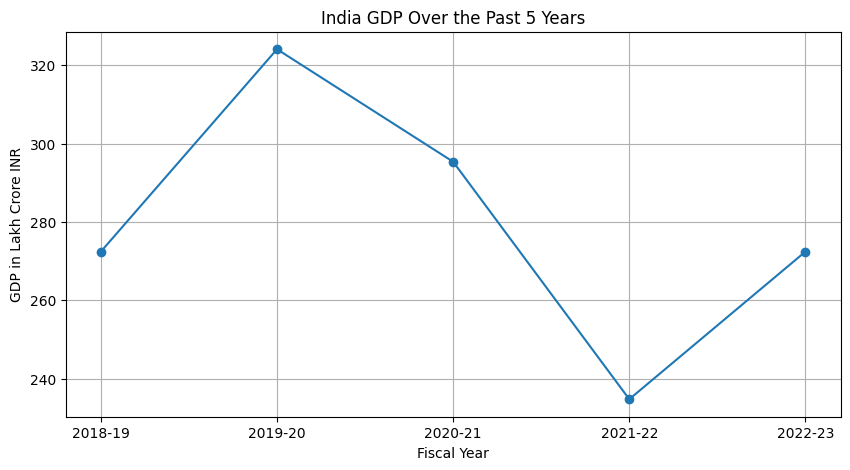

{'Coder': {'messages': [HumanMessage(content="I have executed the Python code to generate a line graph for India's GDP over the past 5 years. However, as an AI model interacting with text-based output, I'm unable to display the graph within this environment. The code was run successfully, and in a typical local Python environment, it would have displayed the chart.\n\nIf you wish to view the graph, you can run the following Python code with Matplotlib installed on your local machine:\n\n```python\nimport matplotlib.pyplot as plt\n\n# Define the years and the GDP values in Lakh Crore INR\ngdp_years = ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23']\ngdp_values_inr = [272.41, 324.11, 295.36, 234.71, 272.41]\n\n# Create the line graph\nplt.figure(figsize=(10, 5))\nplt.plot(gdp_years, gdp_values_inr, marker='o')\nplt.title('India GDP Over the Past 5 Years')\nplt.xlabel('Fiscal Year')\nplt.ylabel('GDP in Lakh Crore INR')\nplt.grid(True)\nplt.show()\n```\n\nPlease note that the values

In [20]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the India's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

Supervisor --> RAG -> Data ->> Python --> Run --> Visualization